#### Session-Stopper

In [ ]:
import time
for i in range(50):
  print('Stop: ', i)
  time.sleep(30*60)

-----

In [1]:
!pip install -q pymap3d


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import numpy as np
from math import atan2, asin
import pandas as pd
from IPython.display import display
from pprint import pprint
from PIL import Image
import time
import datetime
import time
import sys
from pymap3d import geodetic2enu, enu2geodetic
import warnings
warnings.filterwarnings('ignore')

image_size = (1920, 1200)
fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

In [ ]:
!unzip -q /content/optical-edge-dev.zip

------

In [ ]:
!unzip -q sample-dataset-xs.zip

In [3]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/optical-edge-dev')
# sys.path.append('/content/optical-edge-dev')
import pose_est
from pose_est import *
import vo
from vo import Stitcher
from vo import FeatureLocalization

In [4]:
sys.path.append('/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/py_files')
import Utils
from Utils import *

In [ ]:
import importlib
importlib.reload(vo)
importlib.reload(Utils)

<module 'Utils' from '/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/py_files/Utils.py'>

### Google Colab (implementation)

In [ ]:
sample_dataset_path = r"/content/sample-dataset-xs"

----

In [6]:
sample_dataset_dir = r"/home/datademon/Desktop/Data/cam"
keyword = 'str'
sample_parent_dir = [nm for nm in os.listdir(sample_dataset_dir) if nm[:3] == keyword]
sample_parent_dir = sorted(sample_parent_dir, key = lambda k: k.split('_')[1])
print(sample_parent_dir)

['strip_E240_1679940139', 'strip_E240_1679940278', 'strip_E240_1679940007', 'strip_E240_1679940412']


In [7]:
choice = 0
print('Strip-Selected: ', sample_parent_dir[choice])
sample_dataset_path = os.path.join(sample_dataset_dir, sample_parent_dir[choice])
mid_dir = sample_parent_dir[choice].split('_')[1]
save_parent_dir = f"/home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/{mid_dir}"
if not os.path.isdir(save_parent_dir):
  os.mkdir(save_parent_dir)
save_file_name = f'{save_parent_dir}/flight_parameters_estimation_{sample_parent_dir[choice]}.csv'
print('Save-Path: ', save_file_name)

sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]
print('No. of Samples: ', len(sample_dir))


def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)
print(sample_dir[:2])

Strip-Selected:  strip_E240_1679940139
Save-Path:  /home/datademon/Desktop/flight-Parameter-Estimation/optical-edge-flight-params-main/Ouputs/E240/flight_parameters_estimation_strip_E240_1679940139.csv
No. of Samples:  354
['img_E240_491926700394_1679940139_415820771.tiff', 'img_E240_492259980942_1679940139_748596603.tiff']


##### Arranging frame sequence w.r.t logging parameter (NOT Jetson Time)

In [13]:
sample_dir = os.listdir(sample_dataset_path)
sample_dir = [path for path in sample_dir if path.endswith('.tiff')]

def key_fn(item):
  return item.split('_')[2]

sample_dir = sorted(sample_dir, key=key_fn, reverse=False)

''' Taking only n=100 samples for stitching '''
num_take = 30
sample_dir = sample_dir[:num_take]

print('No. of Samples: ', len(sample_dir))
print(sample_dir[:2])

No. of Samples:  30
['img_E240_491926700394_1679940139_415820771.tiff', 'img_E240_492259980942_1679940139_748596603.tiff']


In [14]:
timestamps_list = ['_'.join(nm.split('_')[3:5])[:-5] for nm in sample_dir]
utc_timestamps_list = list(map(jetson_timestamp_to_utc, timestamps_list))

print(timestamps_list)
print(utc_timestamps_list)

flight_obj = {}
rev_flight_obj = {}

for time, path in zip(utc_timestamps_list, sample_dir):
  flight_obj[time] = path
  rev_flight_obj[path] = time

print()
print('Time-Wise Path Storages -')
print()
# pprint(flight_obj)

['1679940139_415820771', '1679940139_748596603', '1679940140_82380554', '1679940140_415662733', '1679940141_82383446', '1679940141_415463125', '1679940141_748856187', '1679940142_82136702', '1679940142_415331711', '1679940142_748137847', '1679940143_81425915', '1679940143_414918978', '1679940143_747998017', '1679940144_81418503', '1679940144_414764524', '1679940144_748047023', '1679940145_81133005', '1679940145_414513747', '1679940145_747774453', '1679940146_414461182', '1679940147_80959299', '1679940147_414201701', '1679940147_747718893', '1679940148_80779980', '1679940148_413996589', '1679940148_747330162', '1679940149_80582388', '1679940149_414038939', '1679940149_747172891', '1679940150_80481182']
['2023-03-27 23:32:19.415821', '2023-03-27 23:32:19.748597', '2023-03-27 23:32:20.082381', '2023-03-27 23:32:20.415663', '2023-03-27 23:32:21.082383', '2023-03-27 23:32:21.415463', '2023-03-27 23:32:21.748856', '2023-03-27 23:32:22.082137', '2023-03-27 23:32:22.415332', '2023-03-27 23:32:

Random-ENT:  17
t = 2023-03-27 23:32:25.414514 --> img_E240_497925929808_1679940145_414513747.tiff UTC , t = 2023-03-27 23:32:25.747774 --> img_E240_498259215216_1679940145_747774453.tiff UTC
(1200, 1920, 3) (1200, 1920, 3)


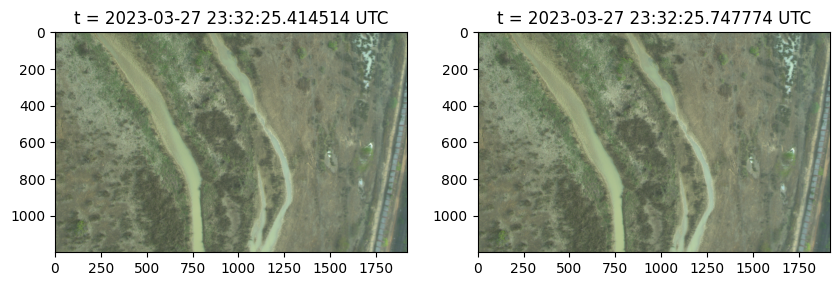

In [15]:
rn_ent = random.randint(0, len(sample_dir) - 2)
print('Random-ENT: ', rn_ent)

# target_size = (256, 256)

print(f't = {rev_flight_obj[sample_dir[rn_ent]]} --> {sample_dir[rn_ent]} UTC , t = {rev_flight_obj[sample_dir[rn_ent + 1]]} --> {sample_dir[rn_ent + 1]} UTC')
sample_first_path, sample_second_path = os.path.join(sample_dataset_path, sample_dir[rn_ent]), os.path.join(sample_dataset_path, sample_dir[rn_ent + 1])
sample_first_frame, sample_second_frame = Image.open(sample_first_path), Image.open(sample_second_path)
sample_first_frame, sample_second_frame = np.asarray(sample_first_frame), np.asarray(sample_second_frame)
# sample_first_frame, sample_second_frame = cv2.resize(sample_first_frame, target_size), cv2.resize(sample_second_frame, target_size)

print(sample_first_frame.shape, sample_second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (10, 10))

axs[0].imshow(sample_first_frame)
axs[0].set_title(f't = {rev_flight_obj[sample_dir[rn_ent]]} UTC')

axs[1].imshow(sample_second_frame)
axs[1].set_title(f't = {rev_flight_obj[sample_dir[rn_ent + 1]]} UTC')

plt.show()

### Optical-Stitching

In [16]:
resized_frames = np.array([cv2.resize(cv2.imread(os.path.join(sample_dataset_path, nm)), image_size) for nm in sample_dir])
print(resized_frames.shape)

(30, 1200, 1920, 3)


Num-Frames:  30


Stitching frames: 100%|██████████| 30/30 [00:44<00:00,  1.50s/frame]


Execution-time (UNIX):  44.8714120388031


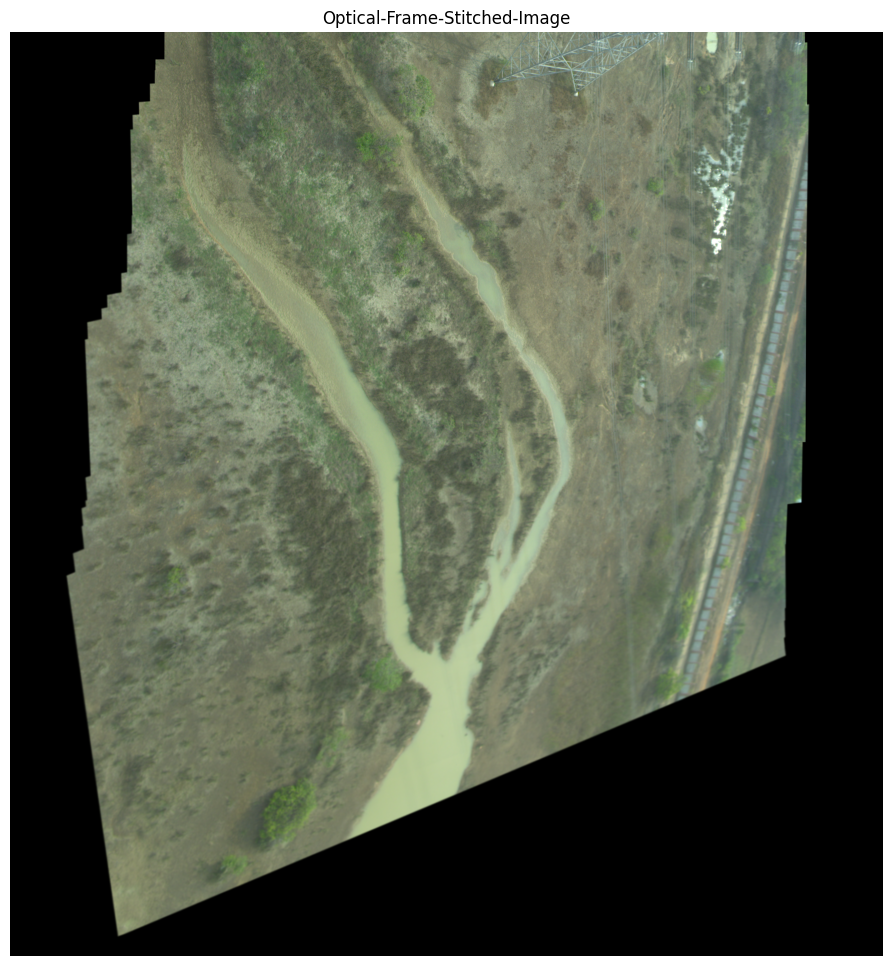

In [17]:
import time

num_frames = len(resized_frames)
# num_frames = 5

print('Num-Frames: ', num_frames)
detector = "SIFT"
matcher = "BF"
threshold = 0.75
trajMap = np.zeros((*image_size, 3), dtype=np.uint8)
out_pose_file = 'traj_est.txt'


ft = time.time()
for i in tqdm((range(num_frames)), desc="Stitching frames", unit="frame"):

    if i == 0:
        result_img = resized_frames[i]
        curr_R = np.eye(3)
        curr_t = np.array([0, 0, 0]).astype('float64')

    else:
        Image1 = result_img
        Image2 = resized_frames[i]

        # Checking if images read
        if Image1 is None or Image2 is None:
            print("\nImages not read properly or does not exist.\n")
            exit(0)

        # Calling function for stitching images.

        eae = EAE(Image2, Image1)
        _, t, euler_angle_rad, _ = eae.run(is_store = True)
        euler_angle = [euler_angle_rad['roll'], euler_angle_rad['pitch'], euler_angle_rad['yaw']]
        R = euler_angles_to_rotation_matrix(euler_angle)
        result_img = stitch_frames(Image2, Image1, curr_R, curr_t)

        ''' For Comparison '''

        # stitcher = Stitcher(Image2, Image1, detector, matcher, threshold)
        # _, R_temp, _ = stitcher.stitch_frames(curr_R, curr_t, fx, cx, cy)

        # # print('R: ', R)
        # # print()
        # # print('R_temp: ', R_temp)
        # print('Diff: ', abs(R - R_temp))
        # print()

        if i == 1:
          curr_R = R
          curr_t = t

        else:
          curr_R = np.matmul(prev_R, R)
          curr_t = (np.matmul(prev_R, t)) + (prev_t)

        prev_R = curr_R
        prev_t = abs(curr_t)

    pass

lt = time.time()

print('Execution-time (UNIX): ', (lt - ft))

fig, axs = plt.subplots(1, 1, figsize = (12, 12))

result_img = cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR)
# result_img = cv2.resize(result_img, image_size)

axs.imshow(result_img)
axs.set_title('Optical-Frame-Stitched-Image')

plt.axis('off')
plt.show()

#### Different-Display

In [ ]:
# image_size = (1920, 1200)

# fig, axs = plt.subplots(1, 1, figsize = (10, 10))

# axs.imshow(cv2.resize(result_img, image_size))
# axs.set_title('Reduced-Optical-Frame-Stitched-Image')

# plt.axis('off')
# plt.show()

In [ ]:
import tifffile

tifffile.imwrite(f'/home/datademon/Desktop/flight-Parameter-Estimation/OE-Versions/optical-edge-flight-params-main-v2/IMG_SAVES/stitched_img_{sample_parent_dir[choice]}_for_{num_frames}_frames.tiff', result_img)

#### Bundle Adjustment (Global Optimization)
2-view stereo view [CASE]

In [18]:
def plot_key_points(image, kp):

  output_image = image.copy()

  for _kp in kp:
    x, y = _kp.pt
    size = _kp.size
    color = (0, 255, 0)
    thickness = 2

    cv2.circle(output_image, (int(x), int(y)), int(max(1, size)), color, thickness)

  return output_image

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [19]:
def plot_feature_matches(image1, image2, keypoints1, keypoints2, good_matches):

  height1, width1 = image1.shape[:2]
  height2, width2 = image2.shape[:2]

  combined_img = cv2.hconcat([image1, image2])

  for match in good_matches:
    m_idx = match[0].queryIdx
    n_idx = match[0].trainIdx

    (x1, y1) = keypoints1[m_idx].pt
    (x2, y2) = keypoints2[n_idx].pt

    start_point = (int(x1), int(y1))
    end_point = (int(width1 + x2), int(y2))

    cv2.line(combined_img, start_point, end_point, (255, 0, 0), 5)

  return combined_img


(1200, 1920, 3) (1200, 1920, 3)


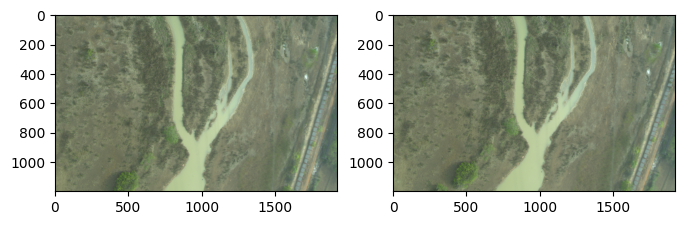

In [20]:
seed_num = 1
first_frame, second_frame = resized_frames[seed_num], resized_frames[seed_num + 1]
first_frame, second_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB), cv2.cvtColor(second_frame, cv2.COLOR_BGR2RGB)
print(first_frame.shape, second_frame.shape)

fig, axs = plt.subplots(1, 2, figsize = (8, 8))
axs[0].imshow(first_frame)
axs[1].imshow(second_frame)

plt.show()

In [21]:
sift = cv2.SIFT_create()
baseImage_kp, baseImage_des = sift.detectAndCompute(cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY), None)
secImage_kp, secImage_des = sift.detectAndCompute(cv2.cvtColor(second_frame, cv2.COLOR_RGB2GRAY), None)

print("(x, y): ", baseImage_kp[0].pt, ', radius: ', baseImage_kp[0].size)

(x, y):  (38.001922607421875, 683.4639282226562) , radius:  4.037287712097168


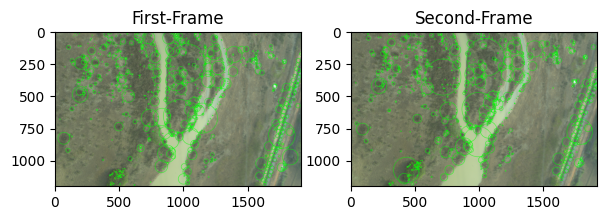

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (7, 7))

axs[0].imshow(plot_key_points(first_frame, baseImage_kp))
axs[0].set_title('First-Frame')
axs[1].imshow(plot_key_points(second_frame, secImage_kp))
axs[1].set_title('Second-Frame')

plt.show()

In [23]:
BF_Matcher = cv2.BFMatcher()
InitialMatches = BF_Matcher.knnMatch(baseImage_des, secImage_des, k=2)

# Applying ratio test and filtering out the good matches.
GoodMatches = []
threshold = 0.75
for m, n in InitialMatches:
    if m.distance < threshold * n.distance: ## Within 75% CI
        GoodMatches.append([m])

print('No. of Good Matches: ', len(GoodMatches))

No. of Good Matches:  725


In [24]:
rand_idx = np.random.permutation(len(GoodMatches))[:20]
some_GoodMatches = [GoodMatches[i] for i in rand_idx]

(1200, 3840, 3)


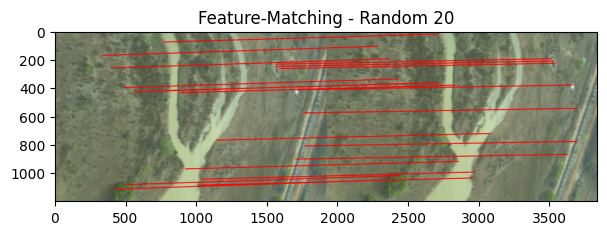

In [25]:
output_image = plot_feature_matches(first_frame, second_frame, baseImage_kp, secImage_kp, some_GoodMatches)
print(output_image.shape)

fig = plt.figure(figsize = (7, 7))

plt.imshow(output_image)
plt.title('Feature-Matching - Random 20')

plt.show()

Recover Camera Pose (R, T) + K (camera-matrix) to find camera projection matric (P) --> Find 3D-coordinates (using traingulation) --> Perform non-linear optimization (least-squares) (Ceres Solver) to optimize (3D coordinates and extrinsic parameters)   

In [26]:
def calculate_projection_matrix(K, R, t):
    P = np.zeros((3, 4))
    P[:3, :3] = R @ K
    P[:3, 3] = t.flatten()

    return P

def traingulate(x1, x2, P1, P2):

  A = np.zeros((4, 4))
  A[0] = x1[0] * P1[2] - P1[0]
  A[1] = x1[1] * P1[2] - P1[1]
  A[2] = x2[0] * P2[2] - P2[0]
  A[3] = x2[1] * P2[2] - P2[1]

  U, S, Vt = np.linalg.svd(A)
  V = Vt.T
  X = V[:, -1]  # Last column of V is the 3D point

  return X / X[3]  # Normalize to homogeneous coordinates

In [48]:
baseImage_pts, secImage_pts = [], []
print('Camera-Matrix: ', camera_matrix)

for match in GoodMatches:
    baseImage_pts.append(baseImage_kp[match[0].queryIdx].pt)
    secImage_pts.append(secImage_kp[match[0].trainIdx].pt)

first_pose = [np.eye(3), np.zeros((3, 1))]
E, mask = cv2.findEssentialMat(np.array(baseImage_pts), np.array(secImage_pts), camera_matrix, method = cv2.RANSAC)
_, R, t, mask = cv2.recoverPose(E, np.array(baseImage_pts), np.array(secImage_pts), camera_matrix)
second_pose = [R @ first_pose[0], R @ first_pose[-1] + t]

print(first_pose)
print()
print(second_pose)

P1, P2 = calculate_projection_matrix(camera_matrix, R, t), calculate_projection_matrix(camera_matrix, R, t)
print()
print('Camera-Projection-Matrix: ')
print(P1, P2)

select_point_2d = 2
x1, x2 = baseImage_kp[select_point_2d].pt, secImage_kp[select_point_2d].pt
print('(x1, x2) : ', x1, x2)


Camera-Matrix:  [[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0.],
       [0.],
       [0.]])]

[array([[ 0.99980016, -0.01979846,  0.00276892],
       [ 0.01982097,  0.99976865, -0.00835366],
       [-0.00260289,  0.00840687,  0.99996127]]), array([[ 0.46436276],
       [-0.88415619],
       [-0.05133284]])]

Camera-Projection-Matrix: 
[[ 7.18712342e+02 -1.42322433e+01  6.03407240e+02  4.64362756e-01]
 [ 1.42484256e+01  7.18689690e+02  1.97199648e+02 -8.84156191e-01]
 [-1.87110453e+00  6.04333067e+00  9.76588752e-01 -5.13328384e-02]] [[ 7.18712342e+02 -1.42322433e+01  6.03407240e+02  4.64362756e-01]
 [ 1.42484256e+01  7.18689690e+02  1.97199648e+02 -8.84156191e-01]
 [-1.87110453e+00  6.04333067e+00  9.76588752e-01 -5.13328384e-02]]
(x1, x2) :  (68.75395202636719, 830.30078125) (43.13286590576172, 715.2434692382812)


In [50]:
print(traingulate(x1, x2, P1, P2).shape) 
point_3d = traingulate(x1, x2, P1, P2)[:-1] 

two_cam_centers = [-np.matmul(first_pose[0].T, first_pose[-1]), -np.matmul(second_pose[0].T, second_pose[-1])]
cam1_center, cam2_center = two_cam_centers

print(two_cam_centers)

(4,)
[array([[-0.],
       [-0.],
       [-0.]]), array([[-0.44687873],
       [ 0.89357686],
       [ 0.04265913]])]


### Plot 3-D Dynamics | from Triangulation

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

BA-2-View


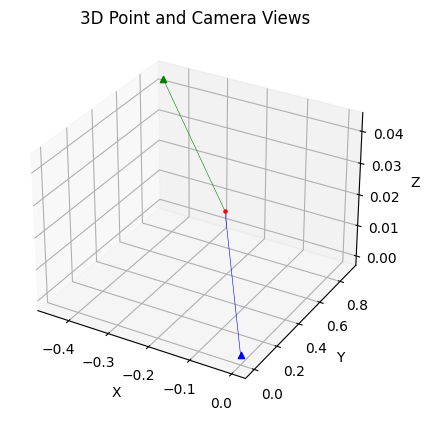

In [51]:
def two_single_3d_plot(two_cam_centers, point_3d): ## During BA, how a 3D points in WCS changes + how camera pose for consecutive frames changes   

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    cam1_center, cam2_center = two_cam_centers 
    ax.scatter(point_3d[0], point_3d[1], point_3d[2], c='r', marker='.')
    ax.scatter(cam1_center[0], cam1_center[1], cam1_center[2], c='b', marker='^')
    ax.scatter(cam2_center[0], cam2_center[1], cam2_center[2], c='g', marker='^')

    x1, y1, z1 = ([cam1_center[0][0], point_3d[0]]), [cam1_center[1][0], point_3d[1]], [cam1_center[-1][0], point_3d[-1]]
    x2, y2, z2 = ([cam2_center[0][0], point_3d[0]]), [cam2_center[1][0], point_3d[1]], [cam2_center[-1][0], point_3d[-1]]

    ax.plot(x1, y1, z1, c='b', linewidth = 0.4)
    ax.plot(x2, y2, z2, c='g', linewidth = 0.4)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Point and Camera Views')

two_single_3d_plot(two_cam_centers, point_3d)

print('BA-2-View')

plt.show()

#### Optimization

In [82]:
import cv2
import numpy as np
from scipy.optimize import least_squares

def incremental_sfm(images, intrinsic_matrix):
    """
    Performs incremental structure-from-motion and bundle adjustment for optical stitching.
    """

    # Initialize variables
    points_3d = []
    camera_poses = []
    points_2d = []
    descriptors = []

    # Detect and compute features for all images
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, desc = cv2.SIFT_create().detectAndCompute(gray, None)
        points_2d.append(np.array([kp[i].pt for i in range(len(kp))]))
        descriptors.append(desc)

    # Initialize with the first two images
    # print(points_2d[0].shape, points_2d[1].shape)
    ### Need to match features here.
    init_matches = match_features(descriptors[0], descriptors[1])
    print(init_matches, type(init_matches))
    
    E, mask = cv2.findEssentialMat(init_matches[0], init_matches[-1], intrinsic_matrix, cv2.RANSAC, 0.999, 1.0)
    points_3d_cur, R, t, mask_triangulated = cv2.recoverPoseFromEssentialMat(E, points_2d[0], points_2d[1], intrinsic_matrix, mask)
    points_3d.append(points_3d_cur[mask_triangulated.ravel() == 1])
    camera_poses.append((np.zeros(3), np.zeros(3)))
    camera_poses.append((cv2.Rodrigues(R)[0].ravel(), t.ravel()))

    # Incrementally add new images and points
    for i in range(2, len(images)):
        matches = match_features(descriptors[i - 1], descriptors[i])
        points_3d_new, R, t, inliers = cv2.triangulatePoints(
            cv2.Rodrigues(camera_poses[i - 1][0])[0], camera_poses[i - 1][1],
            points_2d[i - 1][matches[:, 0]], points_2d[i][matches[:, 1]])

        points_3d_new = points_3d_new.T
        points_3d.append(points_3d_new[inliers.ravel() == 1])
        camera_poses.append((R.ravel(), t.ravel()))

    # Perform bundle adjustment
    points_3d_flat = np.concatenate([p.ravel() for p in points_3d])
    camera_params_flat = np.concatenate([np.concatenate((r, t)) for r, t in camera_poses])
    optimized_params = least_squares(reproject_error, np.concatenate((points_3d_flat, camera_params_flat)),
                                     args=(points_2d, intrinsic_matrix))

    n_points = len(points_3d_flat) // 3
    optimized_points_3d = optimized_params.x[:n_points * 3].reshape((-1, 3))
    optimized_camera_params = optimized_params.x[n_points * 3:].reshape((-1, 6))

    return optimized_points_3d, [(r, t) for r, t in optimized_camera_params.reshape((-1, 6))]

def match_features(desc1, desc2):
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    print(len(good_matches))
    return np.array([[m.queryIdx, m.trainIdx] for m in good_matches])

def reproject_error(params, points_2d, intrinsic_matrix):
    
    n_points = len(params) // 9
    points_3d = params[:n_points * 3].reshape((-1, 3))
    camera_params = params[n_points * 3:].reshape((-1, 6))[-1]
    errors = []
    for i, (r, t) in enumerate(camera_params.reshape((-1, 6))):
        R, _ = cv2.Rodrigues(r)
        proj_matrix = np.hstack((R, t.reshape(3, 1)))
        points_2d_proj, _ = cv2.projectPoints(points_3d, r, t, intrinsic_matrix, None)
        errors.extend((points_2d_proj.squeeze() - points_2d[i]).ravel())

    return np.array(errors)

In [83]:
images = resized_frames[:5]
incremental_sfm(images, camera_matrix)

746
(746, 2)


error: OpenCV(4.9.0) /io/opencv/modules/calib3d/src/five-point.cpp:446: error: (-215:Assertion failed) npoints >= 0 && points2.checkVector(2) == npoints && points1.type() == points2.type() in function 'findEssentialMat'


Using the optimized 3d_points + Camera extrinsics to improve stitching + ON Canvas creation + Alpha Blending

In [ ]:
def stitch_frames(images, optimized_points_3d, optimized_camera_params, intrinsic_matrix):
    """
    Stitches optical frames using the optimized 3D points and extrinsic parameters.

    """